In [1]:
import os
import pygmt
import numpy as np
import xesmf as xe
import pandas as pd
import xarray as xr

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

from mycolorpy import colorlist as mcp

from xarray import DataArray
from scipy.ndimage import gaussian_filter
from numpy import deg2rad, sin, cos, meshgrid, gradient

%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
EarthArea = 510.070281e+6

In [3]:
occ_df = pd.read_csv('data/occurrences.csv')

In [4]:
percfile = '../paleo_reef/data/percentPhotozoan_foster.csv'
df = pd.read_csv(percfile)
ShelfArea = df['Tropic Shelf Area vs Earth Area (%)'].values*EarthArea/100
PhotoArea = (ShelfArea*df['Tropic Photozoan Area vs Tropic Shelf Area (%)'].values/100)/1.e5

percfile = '../paleo_reef/data/percentPhotozoan_smooth.csv'
dfs = pd.read_csv(percfile)
ShelSmthfArea = dfs['Tropic Shelf Area vs Earth Area (%)'].values*EarthArea/100
PhotoSmthArea = (ShelSmthfArea*dfs['Tropic Photozoan Area vs Tropic Shelf Area (%)'].values/100)/1.e5

In [11]:

import pickle
with open('pickle/ed_area_foster.pkl', 'rb') as f:
    fpresArea = pickle.load(f)
    
with open('pickle/ed_area_smooth.pkl', 'rb') as f:
    spresArea = pickle.load(f)
    
farea = []
for k in range(len(fpresArea)):
    farea.append(fpresArea[k][-1]/1.e5)
    
sarea = []
for k in range(len(fpresArea)):
    sarea.append(spresArea[k][-1]/1.e5)

In [16]:
smthArea = []
fostArea = []
smthArea2 = []
fostArea2 = []
for k in range(len(dfs)):
    
    for p in range(len(occ_df)):
        if occ_df['simt'][p] == dfs['Time (Ma)'][k]:
            smthArea.append(PhotoSmthArea[k])
            fostArea.append(PhotoArea[k])
            smthArea2.append(sarea[k])
            fostArea2.append(farea[k])
            break
            
occ_df['smthArea2'] = smthArea2
occ_df['fostArea2'] = fostArea2
occ_df['smthArea'] = smthArea
occ_df['fostArea'] = fostArea
# occ_df

In [18]:
# adding the constant term
x = sm.add_constant(occ_df['fostArea'])
 
# performing the regression
# and fitting the model
result = sm.OLS(occ_df['count'], x).fit()


# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.1553
Date:                Thu, 05 Oct 2023   Prob (F-statistic):              0.696
Time:                        16:01:27   Log-Likelihood:                -184.30
No. Observations:                  42   AIC:                             372.6
Df Residuals:                      40   BIC:                             376.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7030      8.691      3.418      0.0

In [8]:
OLSfit = -0.0184*occ_df['fostArea']+29.7030
st, data, ss2 = summary_table(result, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T


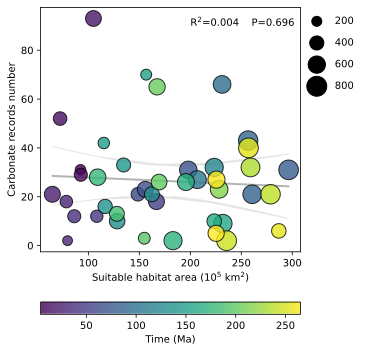

In [9]:
font = {#'family': 'DejaVu Sans',
        'color':  'k',
        'weight': 'normal',
        'size': 10
        }

f, ax = plt.subplots(figsize=(5.3, 5))
ax.set(ylabel='Carbonate records number',
       xlabel='Suitable habitat area (10$^5$ km$^2$)')
sca = plt.scatter(occ_df['fostArea'], occ_df['count'], c = occ_df['simt'], 
            s=0.5*occ_df['mean'], edgecolors='k',alpha=0.8,zorder=3) #, lw='2', ls='-',zorder=3,label='Foster')
plt.plot(occ_df['fostArea'], OLSfit, lw=2, c = 'grey', alpha=0.6)

plt.plot(occ_df['fostArea'], predict_mean_ci_upp, lw=1, c = 'lightgrey', alpha=0.6, zorder=1)
plt.plot(occ_df['fostArea'], predict_mean_ci_low, lw=1, c = 'lightgrey', alpha=0.6, zorder=1)

plt.text(200, 90, r'R$^2$='+str(round(result.rsquared,3)), fontdict=font)
plt.text(260, 90, r'P='+str(round(result.pvalues[1],3)), fontdict=font)


#make a legend:
pws = [200, 400, 600, 800]
for pw in pws:
    plt.scatter([], [], s=pw*0.5, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l, labelspacing=1.2, bbox_to_anchor=(1.24, 1.0), # title="Weighted mean", #borderpad=1, 
            frameon=False, framealpha=0.6, edgecolor="k", facecolor="w")

# instance is used to divide axes
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size = "5%",
                           pad = 0.7,
                           pack_start = True)
f.add_axes(cax)
 
# creating colorbar
f.colorbar(sca, cax = cax, orientation = "horizontal",label="Time (Ma)")
# plt.colorbar(label="Time (Ma)",shrink=0.5)
f.tight_layout()
plt.savefig('figs/foster_relation_area_fossil.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()
plt.close()

In [42]:
# adding the constant term
x = sm.add_constant(occ_df['fostArea2'])
 
# performing the regression
# and fitting the model
result = sm.OLS(occ_df['count'], x).fit()


# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                   0.03041
Date:                Thu, 05 Oct 2023   Prob (F-statistic):              0.862
Time:                        16:31:37   Log-Likelihood:                -184.37
No. Observations:                  42   AIC:                             372.7
Df Residuals:                      40   BIC:                             376.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.9226      8.722      3.201      0.0

In [43]:
OLSfit = -0.0088*occ_df['fostArea2']+27.9226
st, data, ss2 = summary_table(result, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T


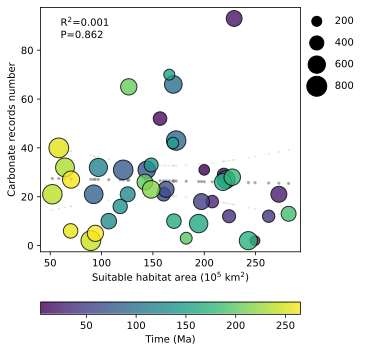

In [44]:
font = {#'family': 'DejaVu Sans',
        'color':  'k',
        'weight': 'normal',
        'size': 10
        }

f, ax = plt.subplots(figsize=(5.3, 5))
ax.set(ylabel='Carbonate records number',
       xlabel='Suitable habitat area (10$^5$ km$^2$)')
sca = plt.scatter(occ_df['fostArea2'], occ_df['count'], c = occ_df['simt'], 
            s=0.5*occ_df['mean'], edgecolors='k',alpha=0.8,zorder=3) #, lw='2', ls='-',zorder=3,label='Foster')
plt.scatter(occ_df['fostArea2'], OLSfit, lw=2, s=2, c = 'grey', alpha=0.6)

plt.scatter(occ_df['fostArea2'], predict_mean_ci_upp, lw=1, s=1,c = 'lightgrey', alpha=0.6, zorder=1)
plt.scatter(occ_df['fostArea2'], predict_mean_ci_low, lw=1, s=1,c = 'lightgrey', alpha=0.6, zorder=1)

plt.text(60, 90, r'R$^2$='+str(round(result.rsquared,3)), fontdict=font)
plt.text(60, 85, r'P='+str(round(result.pvalues[1],3)), fontdict=font)


#make a legend:
pws = [200, 400, 600, 800]
for pw in pws:
    plt.scatter([], [], s=pw*0.5, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l, labelspacing=1.2, bbox_to_anchor=(1.24, 1.0), # title="Weighted mean", #borderpad=1, 
            frameon=False, framealpha=0.6, edgecolor="k", facecolor="w")

# instance is used to divide axes
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size = "5%",
                           pad = 0.7,
                           pack_start = True)
f.add_axes(cax)
 
# creating colorbar
f.colorbar(sca, cax = cax, orientation = "horizontal",label="Time (Ma)")
# plt.colorbar(label="Time (Ma)",shrink=0.5)
f.tight_layout()
plt.savefig('figs/foster_relation_area_fossil2.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()
plt.close()

In [29]:
# adding the constant term
x = sm.add_constant(occ_df['smthArea'])
 
# performing the regression
# and fitting the model
result = sm.OLS(occ_df['count'], x).fit()


# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.1793
Date:                Thu, 05 Oct 2023   Prob (F-statistic):              0.674
Time:                        16:05:37   Log-Likelihood:                -184.29
No. Observations:                  42   AIC:                             372.6
Df Residuals:                      40   BIC:                             376.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7967      8.372      3.559      0.0

In [30]:
OLSfit = -0.0189*occ_df['smthArea']+29.7967 
st, data, ss2 = summary_table(result, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T

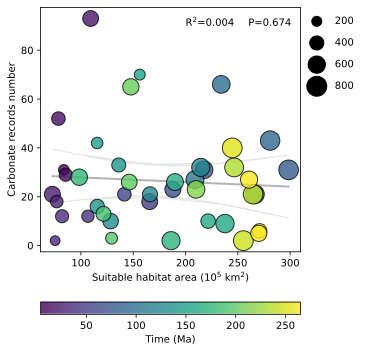

In [31]:
font = {#'family': 'DejaVu Sans',
        'color':  'k',
        'weight': 'normal',
        'size': 10
        }

f, ax = plt.subplots(figsize=(5.3, 5))
ax.set(ylabel='Carbonate records number',
       xlabel='Suitable habitat area (10$^5$ km$^2$)')
sca = plt.scatter(occ_df['smthArea'], occ_df['count'], c = occ_df['simt'], 
            s=0.5*occ_df['mean'], edgecolors='k',alpha=0.8,zorder=3) #, lw='2', ls='-',zorder=3,label='Foster')
plt.plot(occ_df['smthArea'], OLSfit, lw=2, c = 'grey', alpha=0.6)

plt.plot(occ_df['smthArea'], predict_mean_ci_upp, lw=1, c = 'lightgrey', alpha=0.6, zorder=1)
plt.plot(occ_df['smthArea'], predict_mean_ci_low, lw=1, c = 'lightgrey', alpha=0.6, zorder=1)

plt.text(200, 90, r'R$^2$='+str(round(result.rsquared,3)), fontdict=font)
plt.text(260, 90, r'P='+str(round(result.pvalues[1],3)), fontdict=font)


#make a legend:
pws = [200, 400, 600, 800]
for pw in pws:
    plt.scatter([], [], s=pw*0.5, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l, labelspacing=1.2, bbox_to_anchor=(1.24, 1.0), # title="Weighted mean", #borderpad=1, 
            frameon=False, framealpha=0.6, edgecolor="k", facecolor="w")

# instance is used to divide axes
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size = "5%",
                           pad = 0.7,
                           pack_start = True)
f.add_axes(cax)
 
# creating colorbar
f.colorbar(sca, cax = cax, orientation = "horizontal",label="Time (Ma)")
# plt.colorbar(label="Time (Ma)",shrink=0.5)
f.tight_layout()
plt.savefig('figs/smooth_relation_area_fossil.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()
plt.close()

In [45]:
# adding the constant term
x = sm.add_constant(occ_df['smthArea2'])
 
# performing the regression
# and fitting the model
result = sm.OLS(occ_df['count'], x).fit()


# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                 0.0005346
Date:                Thu, 05 Oct 2023   Prob (F-statistic):              0.982
Time:                        16:33:28   Log-Likelihood:                -184.38
No. Observations:                  42   AIC:                             372.8
Df Residuals:                      40   BIC:                             376.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.6853      8.588      3.107      0.0

In [46]:
OLSfit = -0.0011*occ_df['smthArea2']+26.6853
st, data, ss2 = summary_table(result, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T

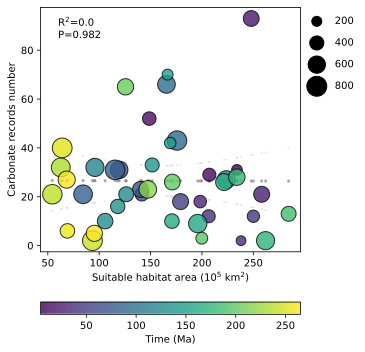

In [47]:
font = {#'family': 'DejaVu Sans',
        'color':  'k',
        'weight': 'normal',
        'size': 10
        }

f, ax = plt.subplots(figsize=(5.3, 5))
ax.set(ylabel='Carbonate records number',
       xlabel='Suitable habitat area (10$^5$ km$^2$)')
sca = plt.scatter(occ_df['smthArea2'], occ_df['count'], c = occ_df['simt'], 
            s=0.5*occ_df['mean'], edgecolors='k',alpha=0.8,zorder=3) #, lw='2', ls='-',zorder=3,label='Foster')
plt.scatter(occ_df['smthArea2'], OLSfit, lw=2, s=2, c = 'grey', alpha=0.6)

plt.scatter(occ_df['smthArea2'], predict_mean_ci_upp, lw=1,s=1, c = 'lightgrey', alpha=0.6, zorder=1)
plt.scatter(occ_df['smthArea2'], predict_mean_ci_low, lw=1, s=1,c = 'lightgrey', alpha=0.6, zorder=1)

plt.text(60, 90, r'R$^2$='+str(round(result.rsquared,3)), fontdict=font)
plt.text(60, 85, r'P='+str(round(result.pvalues[1],3)), fontdict=font)

#make a legend:
pws = [200, 400, 600, 800]
for pw in pws:
    plt.scatter([], [], s=pw*0.5, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l, labelspacing=1.2, bbox_to_anchor=(1.24, 1.0), # title="Weighted mean", #borderpad=1, 
            frameon=False, framealpha=0.6, edgecolor="k", facecolor="w")

# instance is used to divide axes
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size = "5%",
                           pad = 0.7,
                           pack_start = True)
f.add_axes(cax)
 
# creating colorbar
f.colorbar(sca, cax = cax, orientation = "horizontal",label="Time (Ma)")
# plt.colorbar(label="Time (Ma)",shrink=0.5)
f.tight_layout()
plt.savefig('figs/smooth_relation_area_fossil2.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()
plt.close()

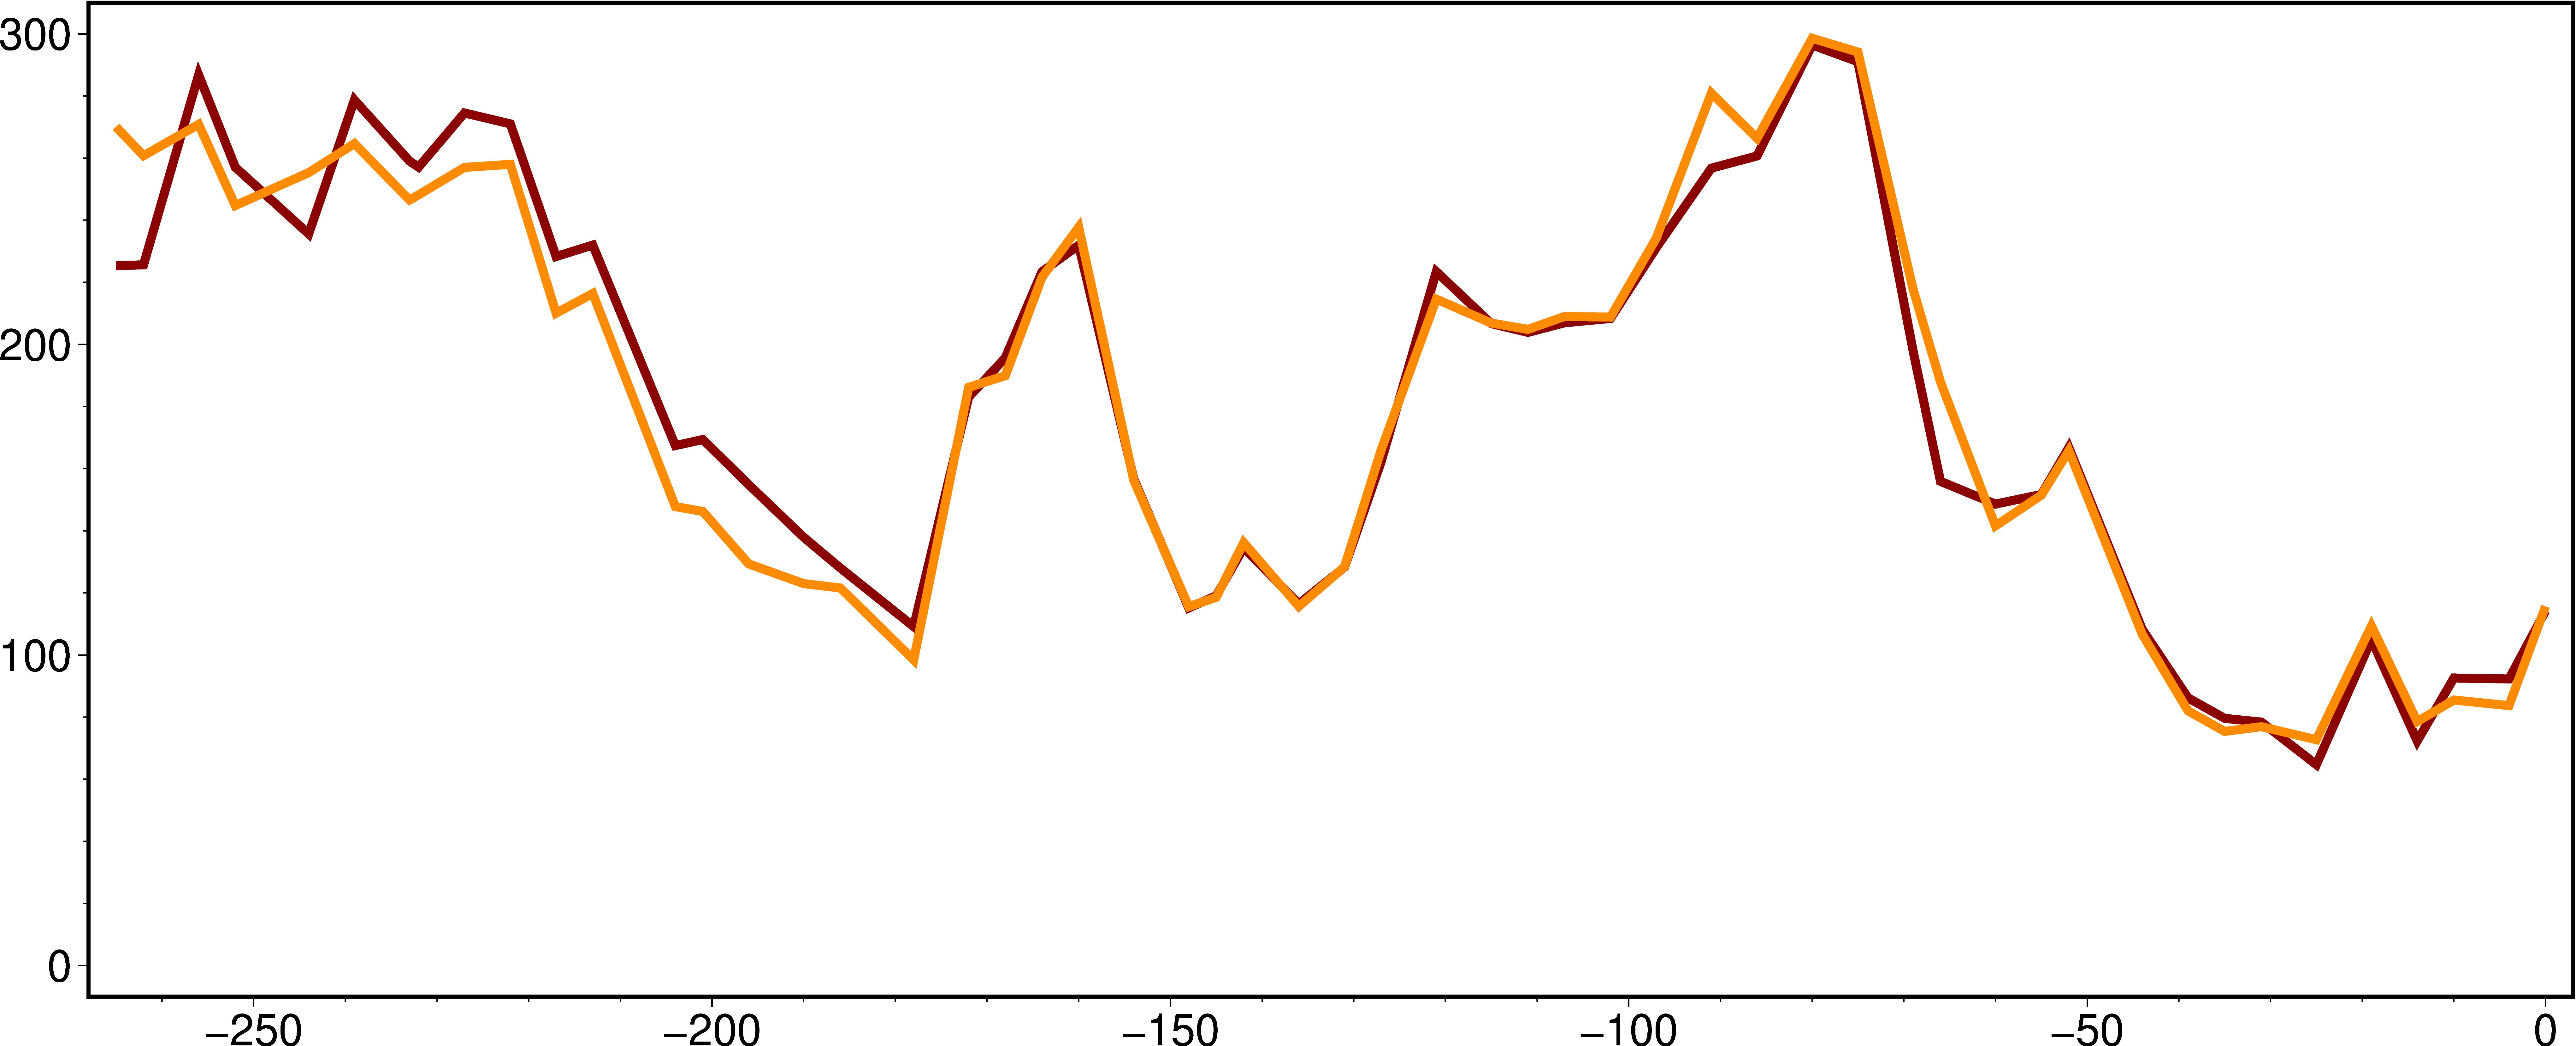

In [35]:
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='20p,Helvetica,black'):
    fig.basemap(region=[-268, 3, -10, 310], projection="X40c/16c", frame='af')
    
    fig.plot(
        frame="a",
        x=-df['Time (Ma)'],
        y=PhotoArea,
#         transparency=1,
#         ='f1c/0.25c+c',
#         style='f1c/0.4c+c+p2p,darkred', fill="white",
        pen="4p,darkred",
    )
    
    fig.plot(
        frame="a",
        x=-dfs['Time (Ma)'],
        y=PhotoSmthArea,
#         transparency=1,
#         ='f1c/0.25c+c',
#         style='f2c/0.4c+c+p2p,darkorange', fill="white",
        pen="4p,darkorange",
    )
    
fig.show(dpi=500, width=700)
# fig.savefig('areaFosterSmooth.png',dpi=500, transparent=True)